In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from gensim.models import Word2Vec,KeyedVectors
import gensim.downloader as api
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import spacy.cli
import spacy
import numpy as np
from random import sample
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

#To download 
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Dataset
- Original dataset: a compilation of reviews from Yelp, TripAdvisor, Google Reviews
- Fake Postive Reviews: Positive reviews about goods from Italian Markets generated by ChatGPT
- Fake Negative Reciews: Negative reviews about goods from Italian Markets generated by ChatGPT 

In [4]:
#Dictionary: Keys=Source, Values=Reviews
#Lists: List of reviews for each dataset

reviews = []
reviews_dict = {}

reviews_dict['original review'] = []
reviews_dict['fake positive review'] = []
reviews_dict['fake negative review'] = []

#Original Revews
orig_reviews = pd.read_csv('/content/drive/MyDrive/reviews/Altomontes_reviews.csv')
for rev in orig_reviews.Review:
  reviews_dict['original review'].append(rev)
  reviews.append((rev,'original review'))

#positive reviews
pos_reviews = pd.read_csv('/content/drive/MyDrive/reviews/generated_positive_reviews - Sheet1.csv')
for rev in pos_reviews.Review:
  reviews.append((rev,'fake positive review'))
  reviews_dict['fake positive review'].append(rev)

#negstive reviews
neg_reviews = pd.read_csv('/content/drive/MyDrive/reviews/generated_negative_reviews - Sheet1.csv')
for rev in neg_reviews.Review:
  reviews.append((rev,'fake negative review'))
  reviews_dict['fake negative review'].append(rev)

## Realism Assessment

In [36]:
def assess_sentence_realism(sentence, model):
    """
  A function that accepts a sentence and embeddings model as inputs, and outputs a 
  'realism' score based on the cohesion and similarity between words of the 
  sentence

  Inputs:
  sentence (str): A string of words.
  model (.model): An embedding model (user's choice)

  Returns:
  avg_similarity: An average similarity score between the words of the sentence.

  """
    tokens = sentence.split()

    # Calculate the average similarity between adjacent word pairs
    similarities = []
    for i in range(len(tokens) - 1):
        word1 = tokens[i]
        word2 = tokens[i + 1]
        if word1 in model.key_to_index and word2 in model.key_to_index:
            word1_index = model.key_to_index[word1]
            word2_index = model.key_to_index[word2]
            similarity = model.cosine_similarities(
                model.get_vector(word1),
                [model.get_vector(word2)]
            )[0]
            similarities.append(similarity)

    # Calculate the average similarity score
    if similarities:
        avg_similarity = sum(similarities) / len(similarities)
    else:
        avg_similarity = 0.0

    return avg_similarity

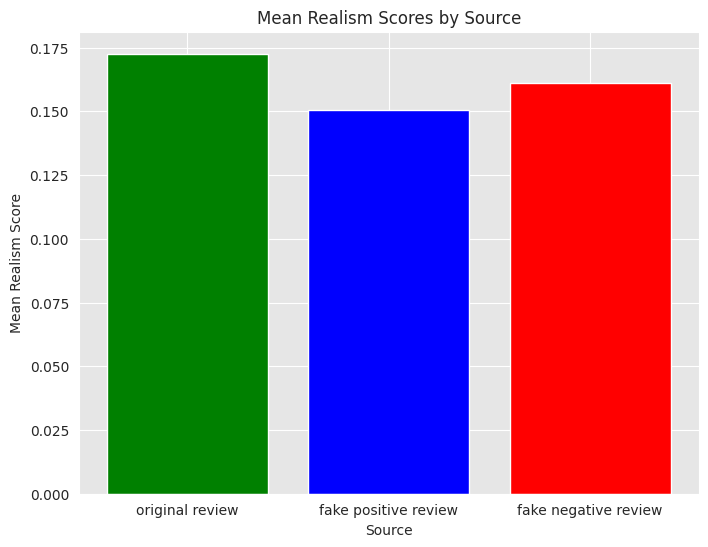

In [37]:


# Download the pre-trained Word2Vec model
#model_name = 'word2vec-google-news-300'  # Example model name
#model = api.load(model_name)
#model.save('/content/drive/MyDrive/models/word2vec-google-news-300.model') 

pretrained_model_path = '/content/drive/MyDrive/models/word2vec-google-news-300.model'
model = KeyedVectors.load(pretrained_model_path)

scores = {}
sources = []

# Evaluate the realism score for each sentence and store in scores dictionary
for sentence, source in reviews:
    realism_score = assess_sentence_realism(sentence, model)
    if source in scores:
        scores[source].append(realism_score)
    else:
        scores[source] = [realism_score]
    sources.append(source)
    #print(f"Realism Score for {source}: {realism_score}")

# Calculate the mean score for each source
mean_scores = {source: np.mean(score_list) for source, score_list in scores.items()}

# Plot the mean scores in a scatter plot
colors = {'original review': 'green','fake positive review':'blue','fake negative review':'red'}
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(8, 6))
plt.bar(mean_scores.keys(), mean_scores.values(),color=['green','blue','red'])
plt.xlabel("Source")
plt.ylabel("Mean Realism Score")
plt.title("Mean Realism Scores by Source")
plt.show()




In [38]:
mean_scores

{'original review': 0.17260327681085103,
 'fake positive review': 0.1506670828405594,
 'fake negative review': 0.16128464449692306}

## Similarity Assessment

In [5]:
def break_dictionary(original_dict, keys_per_dictionary):

  """
  A function that accepts a dictionary and key per dictrionary requirement, 
  outputting new dictionaries bases on the key requirement.

  Input:
  original_dict (dict): Dictionary to be parsed apart
  keys_per_dictionary (int): Requirement for number of keys for the new 
  dictionaries

  Returns:
  separate_dictionaries (dict): A dictionary of dictionaries

  """
  separate_dictionaries = []
  keys = list(original_dict.keys())
  
  for i in range(0, len(keys), keys_per_dictionary):
      chunk_keys = keys[i:i + keys_per_dictionary]
      separate_dict = {key: original_dict[key] for key in chunk_keys}
      separate_dictionaries.append(separate_dict)
  
  return separate_dictionaries

#Creating new dicitonaries
reviews = break_dictionary(reviews_dict,1)

In [9]:
def calculate_cosine_similarity(sentence1, sentence2):
  """
  A function that accepts two sentences as input and outputs their cosine
  similarity

  Inputs:
  sentence1 (str): A string of word
  sentence2 (str): A string of words 

  Returns:
  cosine_sim: Cosine similarity score for the two input sentences
  """
  # Initialize the TfidfVectorizer
  vectorizer = TfidfVectorizer()

  # Create the TF-IDF matrix
  tfidf_matrix = vectorizer.fit_transform([sentence1, sentence2])

  # Calculate the cosine similarity
  cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

  return cosine_sim[0][0]


In [ ]:
#Random Sample 200 Reviews
o_review = sample(reviews_dict['original review'],200)
p_review = sample(reviews_dict['fake positive review'],200)
n_review = sample(reviews_dict['fake negative review'],200)

r_dict = {'original review': o_review,
          'fake positive review': p_review,
          'fake negative review':n_review}


In [8]:

source = ['original review','fake negative review','fake positive review']
source_to_compare = ['original review','fake negative review','fake positive review']
avg_cos_sim_per_word = {}
for s in source:
  count = []
  for s2 in source_to_compare:
    if s != s2:
      for sent in r_dict[s]:
          for sent2 in r_dict[s2]:
            similarity = calculate_cosine_similarity(sent, sent2)
            count.append(similarity)
      avg_cos_sim_per_word['{0} to {1}'.format(s,s2)] = np.mean(count)

In [34]:
results = pd.DataFrame(avg_cos_sim_per_word,index=[0]).T


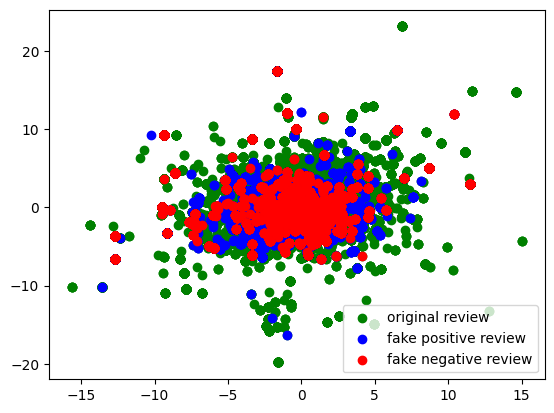

In [13]:
# Load pre-trained GloVe model
nlp = spacy.load('en_core_web_lg')

source_embeddings = {}

for source, source_sentences in reviews_dict.items():
    source_embeddings[source] = []
    for sentence in source_sentences:
        # Tokenize the sentence using spaCy
        doc = nlp(sentence)

        # Retrieve word embeddings
        word_embeddings = np.array([token.vector for token in doc])

        # Save word embeddings for the source
        source_embeddings[source].append(word_embeddings)
def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='lower right')

# Plot embeddings with colors based on source

fig, ax = plt.subplots()
colors = ['g', 'b', 'r']  # Colors for each source
i=0
for source, embeddings in source_embeddings.items():
    for embedding in embeddings:
        ax.scatter(embedding[:, 0], embedding[:, 1], c=colors[i], label=source)
    i+=1
legend_without_duplicate_labels(plt)
plt.show()

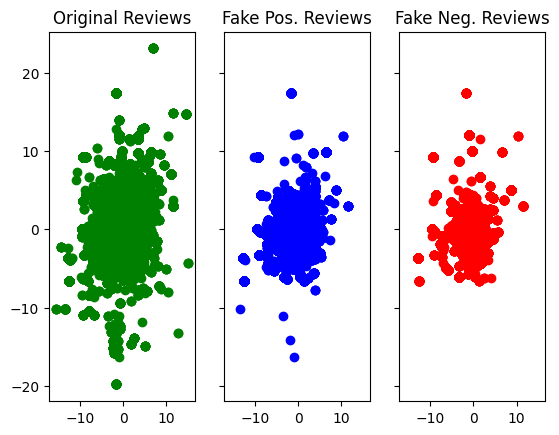

In [14]:
import spacy
import numpy as np
import matplotlib.pyplot as plt

# Load pre-trained GloVe model
nlp = spacy.load('en_core_web_lg')

# Example sentences from different sources
# reviews_dict = {
#     'source1': ['sentence 1', 'sentence 2', 'sentence 3'],
#     'source2': ['sentence 4', 'sentence 5', 'sentence 6'],
#     'source3': ['sentence 7', 'sentence 8', 'sentence 9']
# }

# Retrieve word embeddings for each source
source_embeddings = {}

for source, source_sentences in reviews_dict.items():
    source_embeddings[source] = []
    for sentence in source_sentences:
        # Tokenize the sentence using spaCy
        doc = nlp(sentence)

        # Retrieve word embeddings
        word_embeddings = np.array([token.vector for token in doc])

        # Save word embeddings for the source
        source_embeddings[source].append(word_embeddings)

def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='lower right')

# Plot embeddings with colors based on source
fig, ax = plt.subplots(1,3,sharey=True,sharex=True)
colors = ['r', 'g', 'b']  # Colors for each source
i=0
for source, embeddings in source_embeddings.items():
  if source == 'original review':
    for embedding in embeddings:
      ax[0].scatter(embedding[:, 0], embedding[:, 1], c='g', label=source)
      ax[0].title.set_text('Original Reviews')
  elif source == 'fake positive review':
    for embedding in embeddings:
      ax[1].scatter(embedding[:, 0], embedding[:, 1], c='b', label=source)
      ax[1].title.set_text('Fake Pos. Reviews')
  elif source == 'fake negative review':
    for embedding in embeddings:
      ax[2].scatter(embedding[:, 0], embedding[:, 1], c='r', label=source)
      ax[2].title.set_text('Fake Neg. Reviews')
plt.show()